# Malaria Cell Image Prediction
Kaggle Link : https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

## Importing the files we need

In [81]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization, Dropout
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

warnings.filterwarnings( "ignore")

## Creating Training and Validation datasets from the images

In [2]:
BASE = 'D:/Datasets/Malaria_Pred/cell_images'

In [3]:
os.listdir(BASE)

['Parasitized', 'Uninfected']

In [4]:
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   validation_split=0.2
                                  )

In [5]:
train_gen = train_datagen.flow_from_directory(BASE, class_mode='binary', batch_size=64, target_size = (75,75), shuffle=True, subset='training')
valid_gen = train_datagen.flow_from_directory(BASE, class_mode='binary', batch_size=64, target_size = (75,75), shuffle=True, subset='validation')

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


## Creating out custom model with 3 layers

Each block has 2 Convolutions (5x5 kernels with same padding and activation Relu) followed by Maxpooling (5x5 kernel)
3 such blocks exist, followed by out MLP. The MLP consists of 5 Dense layers, 2 layers for Dropout(50% probability) to ensure no overfitting and 1 Batch Normalization layer to avoid any Internal Covariance Shift.

In [6]:
layers = [   keras.layers.Input((75,75,3)),
             Conv2D(filters=64, kernel_size = (5,5), padding='same', activation='relu'),
             Conv2D(filters=64, kernel_size = (5,5), padding='same', activation='relu'),
             MaxPool2D(3), 
             Conv2D(filters=128, kernel_size = (5,5), padding='same', activation='relu'),
             Conv2D(filters=128, kernel_size = (5,5), padding='same', activation='relu'),
             MaxPool2D(3),
             Conv2D(filters=256, kernel_size = (5,5), padding='same', activation='relu'),
             Conv2D(filters=256, kernel_size = (5,5), padding='same', activation='relu'),
             MaxPool2D(5),
             Flatten(),
             Dense(512, activation='relu'),
             Dense(256, activation='relu'),
             Dropout(0.5),
             Dense(128, activation='relu'),
             Dropout(0.5),
             Dense(50, activation='relu'),
             BatchNormalization(),
             Dense(25, activation='relu'),
             Dense(1, activation='sigmoid')  
         ]

custom_model = Sequential(layers)

We use the Adam optimizer with default arguements and also declare binary_crossentropy as out loss metric

In [7]:
custom_model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['acc'])

In [8]:
custom_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 75, 75, 64)        4864      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 128)       204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 25, 128)       409728    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         8

We fit the model for 20 epochs without any callbacks

In [9]:
custom_model_history = custom_model.fit(train_gen, epochs=20, validation_data=valid_gen)

Epoch 1/20
345/345 [==============================] - 55s 146ms/step - loss: 0.7109 - acc: 0.5577 - val_loss: 0.6086 - val_acc: 0.6744
Epoch 2/20
345/345 [==============================] - 50s 145ms/step - loss: 0.6953 - acc: 0.5370 - val_loss: 0.8454 - val_acc: 0.5000
Epoch 3/20
345/345 [==============================] - 50s 146ms/step - loss: 0.6193 - acc: 0.6611 - val_loss: 0.8331 - val_acc: 0.5000
Epoch 4/20
345/345 [==============================] - 52s 149ms/step - loss: 0.3235 - acc: 0.8836 - val_loss: 0.2998 - val_acc: 0.9372
Epoch 5/20
345/345 [==============================] - 52s 150ms/step - loss: 0.1948 - acc: 0.9427 - val_loss: 0.1883 - val_acc: 0.9436
Epoch 6/20
345/345 [==============================] - 53s 154ms/step - loss: 0.1683 - acc: 0.9510 - val_loss: 0.2318 - val_acc: 0.9397
Epoch 7/20
345/345 [==============================] - 52s 151ms/step - loss: 0.1590 - acc: 0.9545 - val_loss: 0.1952 - val_acc: 0.9441
Epoch 8/20
345/345 [==============================] - 5

## Building the model using transfer learning using the VGG16 and VGG19 Models trained on the Imagenet dataset 

We will import these models without Top as we will only be using this as a preprocessor for out dataset. We will define out own MLP to work on top of both the models' outputs

In [10]:
vgg19_app = VGG19(include_top=False, input_shape=(75,75,3), pooling='max')
vgg16_app = VGG16(include_top=False, input_shape=(75,75,3), pooling='max')

We ensure that the Convolution kernels do not change while training

In [11]:
for layer in vgg16_app.layers:
    layer.trainable = False
for layer in vgg19_app.layers:
    layer.trainable = False

We will add 3 trainable dense layers to both VGG19 and VGG16 and then see which gives better accuracy over 20 epochs
<br> <br>
The Trainable Layers will be : Flatten()----DENSE(1024, relu)---DROPOUT(0.4) --- DENSE(512, relu)---BatchNormalization---DENSE(256, relu)--DENSE(1, sigmoid)

## VGG19 + custom top

In [12]:
op_vgg19 = Flatten()(vgg19_app.output)
op_vgg19 = Dense(1024, activation='relu')(op_vgg19)
op_vgg19 = Dropout(0.4)(op_vgg19)
op_vgg19 = Dense(512, activation='relu')(op_vgg19)
op_vgg19 = BatchNormalization()(op_vgg19)
op_vgg19 = Dense(256, activation='relu')(op_vgg19)
op_vgg19 = Dense(1, activation='sigmoid')(op_vgg19)

In [13]:
vgg19_model = keras.Model(vgg19_app.inputs, op_vgg19)

In [14]:
vgg19_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 75, 75, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0     

In [15]:
vgg19_model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['acc'])
custom_vgg19_history = vgg19_model.fit(train_gen, epochs=20, validation_data=valid_gen)

Epoch 1/20
345/345 [==============================] - 68s 186ms/step - loss: 0.4391 - acc: 0.7983 - val_loss: 0.3751 - val_acc: 0.8336
Epoch 2/20
345/345 [==============================] - 59s 171ms/step - loss: 0.3164 - acc: 0.8674 - val_loss: 0.2939 - val_acc: 0.8706
Epoch 3/20
345/345 [==============================] - 66s 190ms/step - loss: 0.2938 - acc: 0.8809 - val_loss: 0.2904 - val_acc: 0.8837
Epoch 4/20
345/345 [==============================] - 60s 175ms/step - loss: 0.3059 - acc: 0.8758 - val_loss: 0.2831 - val_acc: 0.8802
Epoch 5/20
345/345 [==============================] - 67s 195ms/step - loss: 0.2917 - acc: 0.8794 - val_loss: 0.2880 - val_acc: 0.8817
Epoch 6/20
345/345 [==============================] - 62s 178ms/step - loss: 0.2839 - acc: 0.8829 - val_loss: 0.2921 - val_acc: 0.8869
Epoch 7/20
345/345 [==============================] - 62s 180ms/step - loss: 0.2696 - acc: 0.8923 - val_loss: 0.2981 - val_acc: 0.8880
Epoch 8/20
345/345 [==============================] - 6

## VGG16 + Custom top 

In [16]:
op_vgg16 = Flatten()(vgg16_app.output)
op_vgg16 = Dense(1024, activation='relu')(op_vgg16)
op_vgg16 = Dropout(0.4)(op_vgg16)
op_vgg16 = Dense(512, activation='relu')(op_vgg16)
op_vgg16 = BatchNormalization()(op_vgg16)
op_vgg16 = Dense(256, activation='relu')(op_vgg16)
op_vgg16 = Dense(1, activation='sigmoid')(op_vgg16)

In [17]:
vgg16_model = keras.Model(vgg16_app.inputs, op_vgg16)

In [18]:
vgg16_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 75, 75, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0   

In [19]:
vgg16_model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['acc'])
custom_vgg16_history = vgg16_model.fit(train_gen, epochs=20, validation_data=valid_gen)

Epoch 1/20
345/345 [==============================] - 61s 174ms/step - loss: 0.3895 - acc: 0.8242 - val_loss: 0.2703 - val_acc: 0.8880
Epoch 2/20
345/345 [==============================] - 63s 182ms/step - loss: 0.2763 - acc: 0.8883 - val_loss: 0.3497 - val_acc: 0.8561
Epoch 3/20
345/345 [==============================] - 62s 178ms/step - loss: 0.2622 - acc: 0.8946 - val_loss: 0.3716 - val_acc: 0.8526
Epoch 4/20
345/345 [==============================] - 60s 174ms/step - loss: 0.2543 - acc: 0.8986 - val_loss: 0.2787 - val_acc: 0.8784
Epoch 5/20
345/345 [==============================] - 61s 177ms/step - loss: 0.2567 - acc: 0.8952 - val_loss: 0.2808 - val_acc: 0.8742
Epoch 6/20
345/345 [==============================] - 58s 169ms/step - loss: 0.2529 - acc: 0.8978 - val_loss: 0.2721 - val_acc: 0.8799
Epoch 7/20
345/345 [==============================] - 62s 179ms/step - loss: 0.2496 - acc: 0.9011 - val_loss: 0.2882 - val_acc: 0.8857
Epoch 8/20
345/345 [==============================] - 5

Saving the model histories

In [29]:
with open('custom_model_history', 'wb') as file:
    pickle.dump(custom_model_history.history, file)

with open('vgg19_model_history', 'wb') as file:
    pickle.dump(custom_vgg19_history.history, file)
    
with open('vgg16_model_history', 'wb') as file:
    pickle.dump(custom_vgg16_history.history, file)

In [102]:
models = [custom_model_history.history, custom_vgg19_history.history, custom_vgg16_history.history]
model_name = ['Custom Model', 'VGG19 + Top', 'VGG16 + Top']
metrics = ['acc', 'loss', 'val_acc', 'val_loss' ]
line_var = ['b--', 'r-', 'g-.']

model_info = list(zip(line_var, model_name, models))

## Comparing the Accuracies, Loss, Validation Accuracy and Validation Loss for the 3 models in the same graph

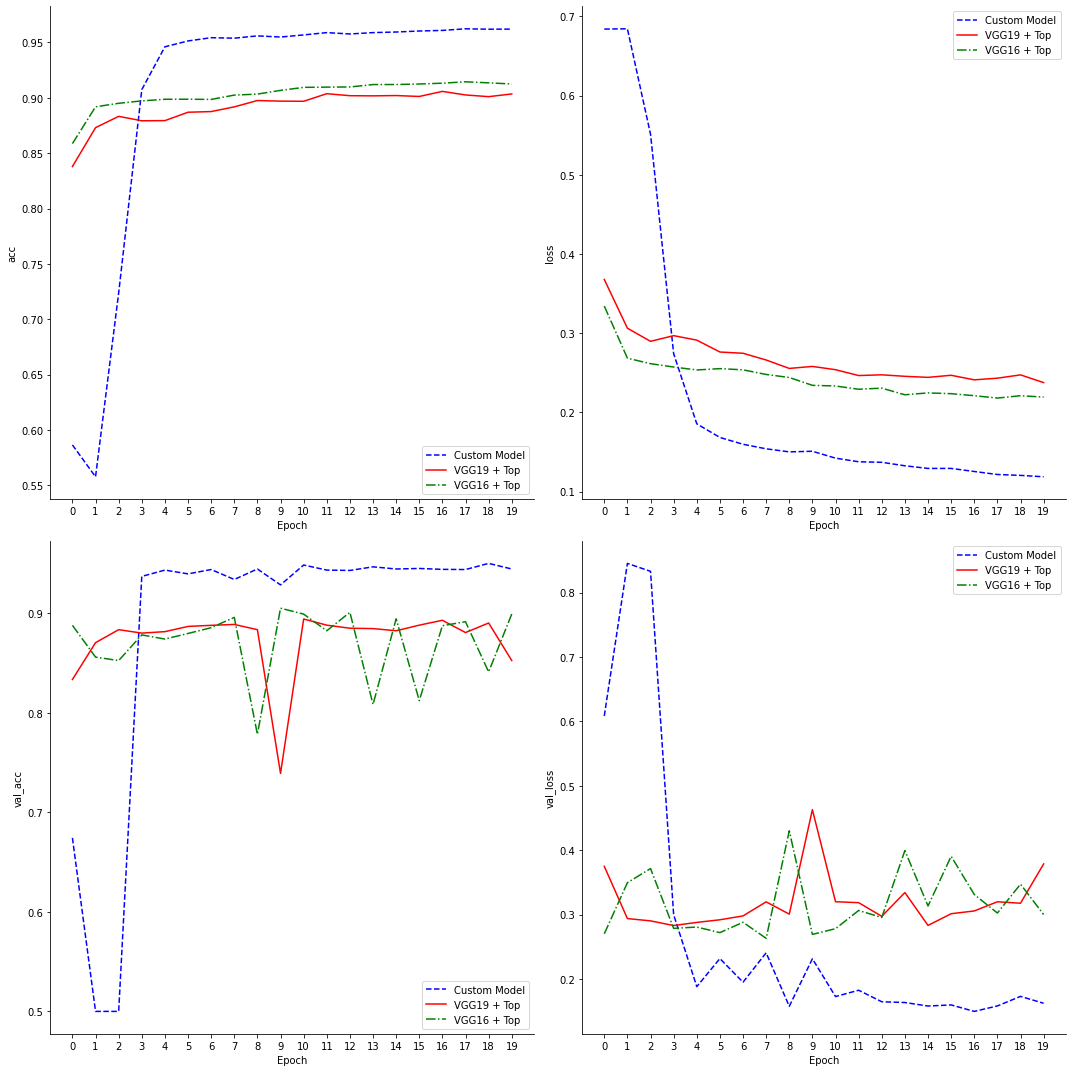

In [111]:
plt.figure(figsize=(15,15))


for i, metric in enumerate(metrics):
    for line, model_name ,model in model_info:
        plt.subplot(2,2,i+1)
        plt.plot(range(0,20), model[metric], line, label = model_name)
        plt.xlabel('Epoch')
        plt.ylabel(metric)
        plt.xticks(range(0,20))
        g = plt.gca()
        g.spines['right'].set_visible(False)
        g.spines['top'].set_visible(False)
        plt.legend();
plt.tight_layout()

In [117]:
print("Number of layers in Vgg19 is", len(vgg19_model.layers))

Number of layers in Vgg19 is 30


In [118]:
print("Number of layers in Vgg16 is", len(vgg16_model.layers))

Number of layers in Vgg16 is 27


In [119]:
print("Number of layers in our custom model is", len(custom_model.layers))

Number of layers in our custom model is 19


<br> <br>

The custom model with 19 layers of Conv2D and maxpooling gives the best result with accuracies as high as 96% on Training Set and 95% on Validation Set
<br>

The VGG16 Model with custom top layer works second best (27 layers) and accuracy goes as high as 91% on Training and 89% on Validation Set
<br>

The VGG19 Model works the worst despite having the highest number of layers (29) with 90% on Training Set and 85% on Validation Set
<br>

This shows that the custom model creates the best features after Convolution and also trains the fastest amongst the 3.